# Proyecto Final Batalla de los Vecindarios

Table of contents
+ Introcucción: Definición del Problema
+ Descripción de los Datos
+ Librerias y Dependencias
+ Exploración de los Datos
+ Variables Geográficas
+ Variables Telecomunicaciones
+ Clustering
+ Resultados
+ Definición del Problema Comercial

Después de la Pandema, se ha observado que muchos han empezado a moverse de las grandes ciudades a hacia ciudades mas pequeñas en busqueda de sitios mas tranquilos gracias a la posibilidad del trabajo virtual.

Por eso un grupo de inversionistas quieren hacer un estudio en la Costa Atlántica Argentina para determinar la ciudad con mayor potencial para desarrollar en un proyecto inmobiliario con todos los servicios para el trabajo desde casa.

# Descripción de los Datos
Los datos necesarios para este analisis son:

**Coordenadas geograficas de la Costa Atlántica:** Coordenadas geográficas de Buenos Aires obtenidos de la pagina Foursquare. https://es.foursquare.com/developers/projects

Datos geográficos de las localidades balnearias de Argentina disponibles en el repositorio público de datos de la Republica Argentina disponible en el siguiente enlace: https://datos.gob.ar/ar/dataset/jgm-servicio-normalizacion-datos-geograficos/archivo/jgm_8.12

**Localidades balnearias de la Costa Atlántica:** Las ciudades balnearias mas importantes de la Costa Atlantica y una lista del top 10 por población según el censo del año 2016, ya que son las ciudades con mas infraestructura son tentativamente la mejor opcion para tener en cuenta en el lugar deseado para invertir, datos obtenidos de Wikipedia según el Censo 2016. https://es.wikipedia.org/wiki/Localidades_balnearias_del_mar_Argentino

**Acceso a Internet fijo por tecnología y Localidad:** Detalle del acceso de Internet y velocidades promedio de Internet fijo por localidad proporcionadas por la ENACOM, ya que se busca localidades con buena infraestructura de servicios de Internet. Datos disponibles por el ente regularor de Telecomunicaciones de Argentina en el siguiente enlace: https://datosabiertos.enacom.gob.ar/dashboards/20000/acceso-a-internet/

Estos datos permitirán a los científicos de datos responder las preguntas de los inversores y determinar en que ciudades conviene desarrollar el proyecto.

# Librerias y Dependencias
Ahora se importa todo lo necesario para hacer el análisis

In [3]:
import numpy as np  # librería para manejar datos vectorizados
import pandas as pd # librería para procesar datos como dataframes 

In [4]:
import matplotlib.pyplot as plt #librería para graficar
%matplotlib inline 

In [5]:
# librería para manejar archivos JSON 
import json 

#!conda install -c conda-forge geopy --yes # retirar el comentario de esta línea si no ha completado el laboratorio de la API de FourSquare 
!pip install geopy
from geopy.geocoders import Nominatim # convertir una dirección en valores de latitud y longitud

import requests # librería para manejar solicitudes
from pandas.io.json import json_normalize # librería para convertir un archivo json en un dataframe pandas

# Matplotlib y módulos asociados para graficar
import matplotlib.cm as cm
import matplotlib.colors as colors

# importar k-means desde la fase de agrupación
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

#!conda install -c conda-forge folium=0.5.0 --yes # retirar el comentario de esta línea si no ha completado el laboratorio de la API de FourSquare
import folium # librería para graficar mapas 

print('Libraries imported.')

Libraries imported.


# Exploración de las Ciudades en la Costa Atlántica Argentina

A continuación, se va a realizar una exploración de las ciudades en la Costa Atlantica y obtener su información geográfica para ver su ubicación y determinar sus características comerciales.

# Obtención de los dataset
Inicialmente se descarga la información geográficas de las ciudades de la Costa Atlántica Argentina desde el repositorio público de datos de Argentina

In [6]:
import wget
url="https://infra.datos.gob.ar/catalog/modernizacion/dataset/7/distribution/7.29/download/localidades-censales.csv"
path="C:/Users/delacruzr/Capstone_BatallaVecindarios/"
wget.download(url,path)

'C:/Users/delacruzr/Capstone_BatallaVecindarios//localidades-censales (1).csv'

In [6]:
url_prov="https://infra.datos.gob.ar/catalog/modernizacion/dataset/7/distribution/7.7/download/provincias.csv"
path="C:/Users/delacruzr/Capstone_BatallaVecindarios/"
wget.download(url_prov,path)

'C:/Users/delacruzr/Capstone_BatallaVecindarios//provincias.csv'

In [7]:
url_internet="http://api.datosabiertos.enacom.gob.ar/api/v2/datastreams/CONEC-AL-SERVI-DE-INTER/data.csv?auth_key=44a38fbffd39c9f7d84e8e7dd2e1d02f0950e611&download=1"
wget.download(url_internet,path)

'C:/Users/delacruzr/Capstone_BatallaVecindarios//data.csv'

In [8]:
localidades=pd.read_csv("localidades-censales.csv")
provincias=pd.read_csv(path+"provincias.csv")
internet=pd.read_csv("data.csv")

# Exploración de los Datos

Las Localidades en Argentina son:

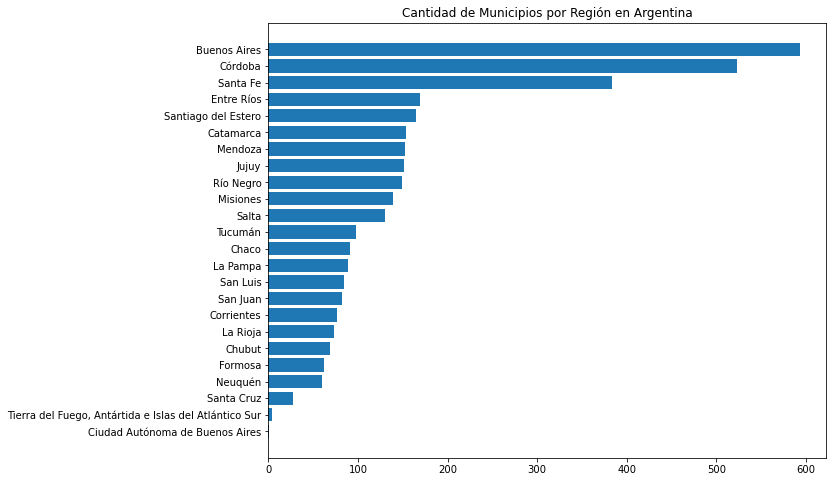

In [9]:
regiones=pd.DataFrame(localidades.groupby(["provincia_nombre"]).size(),columns=['municipios']).sort_values(by="municipios")

# Initialize a Figure and an Axes
fig, ax = plt.subplots()

# Fig size
fig.set_size_inches(10,8)

# Create horizontal bars
ax.barh(y=regiones.index, width=regiones.municipios);

# Add title
ax.set_title('Cantidad de Municipios por Región en Argentina');

El estudio se limita a las provincias con ciudades sobre la Costa Atlantica, estas son Buenos Aires, Rio Negro, Chubut, Santa Cruz y Tierra del Fuego. Por medio de la libreria folium se muestran las localidades seleccionadas en un mapa.

In [10]:
regiones["Provincias"]=regiones.index

geo_prov=regiones.merge(provincias,left_on="Provincias",right_on="nombre")

In [11]:
#url_map="https://dnsg.ign.gob.ar/apps/api/v1/capas-sig/Geodesia+y+demarcaci%C3%B3n/L%C3%ADmites/provincia/json"
url_map="https://infra.datos.gob.ar/catalog/modernizacion/dataset/7/distribution/7.12/download/provincias.geojson"
filename=wget.download(url_map)

print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [12]:
costa_atlan=geo_prov.loc[[1,2,5,15,23]]
costa_atlan=costa_atlan.drop(["categoria","nombre","fuente","id","iso_id","nombre_completo","Provincias"],axis=1)
costa_atlan

,municipios,centroide_lat,centroide_lon,iso_nombre
1,4,-82.521518,-50.742749,Tierra del Fuego
2,27,-48.815485,-69.955762,Santa Cruz
5,69,-43.788623,-68.526759,Chubut
15,149,-40.405796,-67.229330,Río Negro
23,593,-36.676942,-60.558832,Buenos Aires


In [13]:
costa_atlan.reset_index(drop=True,inplace=True)
costa_atlan.rename(columns={"iso_nombre": "Provincia", "B": "c"},inplace=True)

In [14]:
address = 'Argentina'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Argentina are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Argentina are -34.9964963, -64.9672817.


In [15]:
# crear un mapa de Manhattan usando los valores de latitud y longitud
map_costa = folium.Map(location=[latitude, longitude], zoom_start=4)

# añadir los marcadores al mapa
for lat, lng, label in zip(costa_atlan['centroide_lat'], costa_atlan['centroide_lon'], costa_atlan['Provincia']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_costa)  
    
map_costa

In [16]:
costa_atlan

,municipios,centroide_lat,centroide_lon,Provincia
0,4,-82.521518,-50.742749,Tierra del Fuego
1,27,-48.815485,-69.955762,Santa Cruz
2,69,-43.788623,-68.526759,Chubut
3,149,-40.405796,-67.229330,Río Negro
4,593,-36.676942,-60.558832,Buenos Aires


In [7]:
#localidades con acceso al mar fuente Wikipedia
loc_costa=pd.read_csv("Localidades_Costa.csv", encoding='latin-1')

#Se limpia los datos 
costa_limpio=pd.DataFrame(data=loc_costa["Localidades_Costa"].str.strip())

#Se hace merge con el repositorio de localidades
costa_merge=localidades.merge(costa_limpio,left_on='nombre',right_on='Localidades_Costa')

print("Localidades de la Costa",costa_limpio.shape)
print("Merge con el Repositorio",costa_merge.shape)

,categoria,centroide_lat,centroide_lon,departamento_id,departamento_nombre,fuente,funcion,id,municipio_id,municipio_nombre,nombre,provincia_id,provincia_nombre
0,Localidad simple,-37.823387,-60.484640,6014.0,Adolfo Gonzales Chaves,INDEC,NaN,6014030,60014.0,Adolfo Gonzales Chaves,Juan E. Barra,6,Buenos Aires
1,Localidad simple,-37.625498,-58.746186,6063.0,Balcarce,INDEC,NaN,6063030,60063.0,Balcarce,Napaleofú,6,Buenos Aires
2,Localidad simple,-37.542635,-58.340719,6063.0,Balcarce,INDEC,NaN,6063040,60063.0,Balcarce,Ramos Otero,6,Buenos Aires
3,Localidad simple,-38.012284,-58.355378,6063.0,Balcarce,INDEC,NaN,6063050,60063.0,Balcarce,San Agustín,6,Buenos Aires
4,Localidad simple,-37.859629,-57.980601,6063.0,Balcarce,INDEC,NaN,6063060,60063.0,Balcarce,Villa Laguna La Brava,6,Buenos Aires
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3521,Componente de localidad compuesta,-26.815571,-65.269158,90119.0,Yerba Buena,INDEC,CABECERA_DEPARTAMENTO,90119030,908560.0,Municipalidad de Yerba Buena,Yerba Buena - Marcos Paz,90,Tucumán
3522,Localidad simple,-54.637686,-67.766941,94015.0,Ushuaia,INDEC,NaN,94015010,NaN,NaN,Laguna Escondida,94,"Tierra del Fuego, Antártida e Islas del Atlánt..."
3523,Localidad simple,-54.803640,-68.316062,94015.0,Ushuaia,INDEC,CAPITAL_PROVINCIA,94015020,940014.0,Ushuaia,Ushuaia,94,"Tierra del Fuego, Antártida e Islas del Atlánt..."
3524,Localidad simple,-53.787047,-67.713235,94008.0,Río Grande,INDEC,CABECERA_DEPARTAMENTO,94008010,940007.0,Río Grande,Río Grande,94,"Tierra del Fuego, Antártida e Islas del Atlánt..."


In [ ]:
#Se limpia las localidades que pueden tener nombre repetido y esten por fuera de las localidades en análisis.
costa_data=costa_merge[(costa_merge["provincia_nombre"]=="Buenos Aires")|
            (costa_merge["provincia_nombre"]=="Chubut")|
            (costa_merge["provincia_nombre"]=="Santa Cruz")|
            (costa_merge["provincia_nombre"]=="Río Negro")|
            (costa_merge["provincia_nombre"]=="Tierra del Fuego, Antártida e Islas del Atlántico Sur")
            ]

# Variables Geográficas
Obtención de variables por medio del servicio de Foursquare
A continuación vamos a empezar a utilizar el API de FourSquare para explorar las localidades y segmentarlos, por medio de una función que los explore todos.

In [ ]:
CLIENT_ID = 'IEFGX2ZUUERQTSM2F4Z5RZMQ3P5DB2UIRETDUOILZJ1L0T2V' # su ID de Foursquare
CLIENT_SECRET = 'BJUWCYJKD0MBXDKIVDG45P5W2MOHQ5KPBT1OMGZVGW0L13RM' # Secreto de Foursquare
VERSION = '20180605' # versión de la API de Foursquare
LIMIT = 100 # Un valor límite para la API de Foursquare

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # crear la URL de solicitud de API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # solicitud GET
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # regresa solo información relevante de cada sitio cercano
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

De la función se obtienen todas las calles de las ciudades de la costa

In [ ]:
cos_venues = getNearbyVenues(names=costa_data['nombre'],
                                   latitudes=costa_data['centroide_lat'],
                                   longitudes=costa_data['centroide_lon']
                                  )

In [ ]:
cos_venues.groupby('Neighbourhood').count()

In [ ]:
print('Hay {} categorias únicas.'.format(len(cos_venues['Venue Category'].unique())))

# Normalización de Variables

Ahora se prepara el dataset para poder aplicar el modelo de segmentación. Para esto las variables categóricas se pasan a Dummies (1 o 0) y las numéricas se llevan al mismo rango. A este proceso se llama normalización de variables o codificación.

In [ ]:
# codificación
costa_onehot = pd.get_dummies(cos_venues[['Venue Category']], prefix="", prefix_sep="")

# añadir la columna de barrio de regreso al dataframe
costa_onehot['Neighbourhood'] = cos_venues['Neighbourhood'] 

# mover la columna de barrio a la primer columna
fixed_columns = [costa_onehot.columns[-1]] + list(costa_onehot.columns[:-1])
costa_onehot = costa_onehot[fixed_columns]

#Agrupación por el promedio
costa_grouped = costa_onehot.groupby('Neighbourhood').mean().reset_index()

In [ ]:
costa_grouped.head()

Ahora se van a seleccionar los 3 sitios mas comunes de cada localidad. Primero por medio de una función se ordenan los sitios en orden descendente.

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Se genera el nuevo dataframe y con los 3 sitios mas populares de cada localidad.

In [ ]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# crear las columnas acorde al numero de sitios populares
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# crear un nuevo dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = costa_grouped['Neighbourhood']

for ind in np.arange(costa_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(costa_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

# Variables de Telecomunicaciones
A las variables encontradas de categoría de sitios populares, se van a sumar las relacionadas con los servicios de telecomunicaciones. Que detalla las tecnologías disponibles en cada localidad para acceder al servicio de Internet fijo y móvil.

In [ ]:
##Sumar variables de Internet
acceso=internet.drop(["Partido","link","Latitud","Longitud"],axis=1)

#Se limpia las localidades que pueden tener nombre repetido y esten por fuera de las localidades en análisis.
int_var=acceso[(acceso["Provincia"]=="BUENOS AIRES")|
            (acceso["Provincia"]=="CHUBUT")|
            (acceso["Provincia"]=="SANTA CRUZ")|
            (acceso["Provincia"]=="RIO NEGRO")|
            (acceso["Provincia"]=="TIERRA DEL FUEGO")
            ]

In [ ]:
#Se hace un merge para trabajar solo con las localidades en estudio
variables_data=costa_grouped[["Neighbourhood"]].merge(int_var,how="left",left_on="Neighbourhood",right_on="Localidad")

In [ ]:
variables_data.columns

In [ ]:
Index(['Neighbourhood', 'Provincia', 'Localidad', 'Poblacion', 'ADSL',
       'CABLEMODEM', 'DIALUP', 'FIBRAOPTICA', 'SATELITAL', 'WIRELESS',
       'TELEFONIAFIJA', '3G', '4G'],
      dtype='object')

In [ ]:
variables_data.head()

De estas 4 provincias, se seleccionarán las localidades con acceso al mar e infraestructura para disfrutar de las playas, recibir nuevos pobladores.

Se deben normalizar las variables de conexión de Internet para que sean intrepretadas correctamente por el modelo. Para esto se convierte las variables alfanumericas correspondientes a los tipos de conexión a 0 y 1.

In [ ]:
# example of a ordinal encoding
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
#define data
data = variables_data[['ADSL','CABLEMODEM','DIALUP','FIBRAOPTICA','SATELITAL','WIRELESS', 'TELEFONIAFIJA','3G','4G']]
# define ordinal encoding
encoder = OrdinalEncoder()
# transform data
result = encoder.fit_transform(data)

In [ ]:
Convertir de nuevo a un dataframe y unirlo a las variables geográficas ya normalizadas

In [ ]:
#Convertir a un dataframe
internet_grouped=pd.DataFrame(data=result,columns=[data.columns]).reset_index(drop=True)

#Concatenar con las variables geograficas
var_grouped=pd.concat([costa_grouped,internet_grouped], axis=1)

In [ ]:
internet_grouped.describe()

e agrupan los tipos de Acceso, en tres grupos:

+ Red Movil: Accesos de las Red móvil 2G y 3G
+ Red Banda Ancha: Accesos ADSL, Cablemódem y Fibra
+ Red Banda Angosta: Satelital, DialUp y Wireless
+ Teléfono Fijo: Si tiene servicio de telefonia fija

In [ ]:
#Seleccion de Columnas con la información por tipo de red de acceso
internet_data=var_grouped.loc[:,var_grouped.columns[[0] +list(range(76, var_grouped.shape[1]))]]

#Argupaciones
internet_data["Red_Movil"]=np.where(internet_data.iloc[:,8]+internet_data.iloc[:,9]>0,"SI","NO")
internet_data["Red_BandaAncha"]=np.where(internet_data.iloc[:,1]+internet_data.iloc[:,2]+internet_data.iloc[:,4]>0,"SI","NO")
internet_data["Red_BandaAngosta"]=np.where(internet_data.iloc[:,3]+internet_data.iloc[:,5]+internet_data.iloc[:,6]>0,"SI","NO")
internet_data["Telefono_Fijo"]=np.where(internet_data.iloc[:,7]>0,"SI","NO")

#Se dejan solo las columnas agrupadas y se trae la informeación de Población
acceso_data=internet_data.loc[:,internet_data.columns[[0] + list(range(10,internet_data.shape[1]))]]
acceso_data.insert(1,'Poblacion', variables_data["Poblacion"])
acceso_data.head()

Una vez seleccionadas las variables, se aplicará un modelo de clustering.

# Modelamiento Clustering

Para el análisis de agrupamiento, se aplicará el modelo k-means. Inicialmente por medio de la curva del codo (Elbow Curve) se elige el valor de K

In [ ]:
#Variables para el modelo sin el campo Neighbourhood
costa_grouped_clustering = var_grouped.drop('Neighbourhood', 1)

In [ ]:
#Curva del Codo
X=costa_grouped_clustering
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

A partir de la gráfica anterior, se elige como mejor valor para k=3

In [ ]:
# establecer el número de agrupaciones
kclusters = 3

# ejecutar k-means
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(costa_grouped_clustering)

# revisar las etiquetas de las agrupaciones generadas para cada fila del dataframe
kmeans.labels_[0:10] 

Generemos un nuevo dataframe que incluya la agrupación asi como los 3 sitios mas populares de cada localidad.

In [ ]:
costa_localidades=costa_data[["Localidades_Costa","provincia_nombre","centroide_lat","centroide_lon"]].merge(acceso_data,left_on='Localidades_Costa', right_on='Neighbourhood')
costa_localidades=costa_localidades.drop("Neighbourhood",axis=1)
costa_localidades.head()

In [ ]:
# añadir etiquetas
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# juntar costa_grouped con costa_data 
costa_merged = costa_localidades.merge(neighborhoods_venues_sorted,left_on='Localidades_Costa', right_on='Neighbourhood')

costa_merged.head() # revisar las ultimas columnas

Finalmente visualicemos las agrupaciones resultantes

In [ ]:
# crear mapa
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# establecer el esquema de color para las agrupaciones
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# añadir marcadores al mapa
markers_colors = []
for lat, lon, poi, cluster in zip(costa_merged['centroide_lat'], costa_merged['centroide_lon'], costa_merged['Localidades_Costa'], costa_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Análisis de los Resultados
Ahora se hace un análisis de las agrupaciones se determina las categorias del sitio que distingue a cada agrupación.

# Agrupación 1

In [ ]:
costa_merged.loc[costa_merged['Cluster Labels'] == 0, costa_merged.columns[[1] + list(range(4, costa_merged.shape[1]))]].sort_values("Poblacion",ascending=False)

#  Agrupación 2

In [ ]:
costa_merged.loc[costa_merged['Cluster Labels'] == 1, costa_merged.columns[[1] + list(range(4, costa_merged.shape[1]))]].sort_values("Poblacion",ascending=False

# Agrupación 3

In [ ]:
costa_merged.loc[costa_merged['Cluster Labels'] == 2, costa_merged.columns[[1] + list(range(4, costa_merged.shape[1]))]].sort_values("Poblacion",ascending=False)